In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
import matplotlib
import matplotlib_venn as venn
from poola import core as pool
from scipy.stats import combine_pvalues
from adjustText import adjust_text

import core_functions as fns

gpp.set_aesthetics(palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Functions 

In [2]:
def compile_screens(screen_dict):
    '''
    Input: screen_dict: dictionary with dataframes containing the following data from each screen:
            1. Gene Symbol
            2. residual_zscore (gene-level, averaged across conditions if applicable)
            3. Rank (based on residual_zscore)
    Output: if multiple data frames in input, merges; columns renamed to include senior author of screen 
    '''
    for key, df in screen_dict.items():
        new_df = df.copy()
        #data_cols = [col for col in new_df.columns if 'zscore' in col]
        data_cols = new_df.columns[1:]
        for col in data_cols:
            if key not in col:
                new_col = col + '_' + key
                new_df = new_df.rename(columns = {col: new_col})
            else:
                continue
        screen_dict[key] = new_df
    if len(screen_dict) > 1:
        all_screens = fns.merge_dict_dfs(screen_dict, merge_how = 'outer')
        return all_screens
    else: 
        for key, df in screen_dict.items():
            return df

def add_control_col(df, control_names):
    '''
    Inputs: 1. df: dataframe with gene-level processed data (z-score (avg), rank)
            2. control_names: list containing substrings that identify controls
    '''
    if 'control_flag' not in df.columns:
        control_genes = []
        #control_dict = {}
        if len(control_names) >1:
            for ctrl in control_names:
                new_control_genes = df['Gene Symbol'][df['Gene Symbol'].str.contains(ctrl)].to_list()
                control_genes.append(new_control_genes)
            all_control_genes = control_genes[0] + control_genes[1]
            
            control_flag_col = df['Gene Symbol'].isin(all_control_genes)
            df.insert(1, 'control_flag', control_flag_col)
        else:    
            df.insert(1, 'control_flag', df['Gene Symbol'].str.contains(control_names[0]))
            
    return df

def get_controls(df, control_name = [], separate = False):
    '''
    Inputs:
    1. df: Dataframe with columns "Gene Symbol" and data 
    2. control_name: list containing substrings that identify controls (default: 'NO_SITE', 'ONE_INTERGENIC')
    3. separate: determines whether to return non-targeting and intergenic controls separately (default = True)
    '''
    if len(control_name) == 1:
        control = df[df['Gene Symbol'].str.contains(control_name[0], na = False)]
        return control
    else:
        control_dict = {}
        for i, ctrl in enumerate(control_name):
            control_dict[ctrl] = df[df['Gene Symbol'].str.contains(ctrl, na = False)]
        if separate: 
            return control_dict
        else:
            all_controls = pd.concat(list(control_dict.values()))
            return all_controls

def col_avg(df, merge_col = ['Gene Symbol'], col_name = ''):
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data  
    2. merge_col: column to merge averaged dataframe on
    3. col_name: averaged column name 
    Outputs:
    1. avg_df: Data frame with column containing averaged input data  
    '''
    avg_df = df[merge_col].copy()
    if col_name == '':
        avg_col_name = 'avg'
    else:
        avg_col_name = col_name
    avg_df[avg_col_name] = df.mean(axis = 1)
    return avg_df

def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df

## Data Summary

Comparison across the following studies:

***C. sabeus* library**

1. Wilen: 
    * Publication: Wei et al. 
    * Cell line: Vero-E6
2. Goujon:
    * Cell line: Vero-E6
    
**GeCKOv2**
3. Sanjana:
    * Publication: Daniloski et al.
    * Cell line: A549 (overexpressing ACE2) 
4. Puschnik:
    * Publication: Wang et al.
    * Cell line: Huh7.5.1

**Brunello**
5. Poirier:
    * Publication: Schneider et al.
    * Cell line: Huh7.5
6. Daelemans:
    * Publication: Baggen et al. 
    * Cell line: Huh7
7. Goujon:
    * Cell line: Caco-2
8. Zhang:
    * Publication: Zhu et al. 
    * Cell line: A549 (overexpressing ACE2)
    
**Gattinara**
9. Goujon:
    * Cell line: Calu-3
    
**Calabrese Set A and B**
10. Goujon:
    * Cell line: Calu-3
   

## Processed Data: individual screens

In [3]:
# Dictionary definitions 

screen_dict = {}
Vero_dict = {}
GeCKOv2_dict = {}
Brunello_dict = {}

### <i> C. sabeus </i> screens 

In [4]:
#Wilen: Vero-E6
Wilen = pd.read_excel('../../Data/Processed/GEO_Submission_v2/VeroE6_Wilen_v5.xlsx')
Wilen = add_control_col(Wilen, ['NO_SITE'])
screen_dict['Wilen'] = Wilen

#Goujon: Vero-E6
Goujon_Vero = pd.read_excel('../../Data/Processed/GEO_Submission_v2/VeroE6_Goujon_v5.xlsx')
Goujon_Vero = add_control_col(Goujon_Vero, ['NO_SITE'])
screen_dict['Goujon_Vero'] = Goujon_Vero


### GeCKOv2 screens

In [5]:
# Sanjana: A549 (ACE2)
Sanjana = pd.read_excel('../../Data/Processed/GEO_Submission_v2/A549_GeCKOv2_Sanjana_v2.xlsx')
Sanjana = add_control_col(Sanjana, ['NonTargeting'])
screen_dict['Sanjana'] = Sanjana

# Puschnik: Huh-7.5
Puschnik = pd.read_excel('../../Data/Processed/GEO_Submission_v2/Huh751_GeCKOv2_Puschnik.xlsx')
Puschnik = add_control_col(Puschnik, ['dummyguide'])
screen_dict['Puschnik'] = Puschnik


### Brunello screens

In [6]:
# Poirier: Huh-7.5.1
Poirier = pd.read_excel('../../Data/Processed/Geo_Submission_v2/Huh75_Brunello_Poirier_v2.xlsx')
Poirier = add_control_col(Poirier, ['Non-Targeting'])
screen_dict['Poirier'] = Poirier

# Daelemans: Huh-7
Daelemans = pd.read_excel('../../Data/Processed/Geo_Submission_v2/Huh7_Brunello_Daelemans_v2.xlsx')
Daelemans = add_control_col(Daelemans, ['Non-Targeting'])
screen_dict['Daelemans'] = Daelemans

# Zhang: A549 (ACE2)
Zhang = pd.read_excel('../../Data/Processed/Geo_Submission_v2/A549_Brunello_Zhang.xlsx')
Zhang = add_control_col(Zhang, ['Non-Targeting'])
screen_dict['Zhang']= Zhang

# Goujon: Caco-2
Goujon_Caco2 = pd.read_excel('../../Data/Processed/Geo_Submission_v2/Caco2_Brunello_Goujon_v2.xlsx')
Goujon_Caco2= add_control_col(Goujon_Caco2, ['ONE_INTERGENIC_','NO_SITE'])
screen_dict['Goujon_Caco2'] = Goujon_Caco2

### Gattinara screen

In [7]:
# Goujon: Calu-3
Goujon_Calu3_Gat= pd.read_excel('../../Data/Processed/Geo_Submission_v2/Calu3_Gattinara_Goujon_v2.xlsx')
Goujon_Calu3_Gat= add_control_col(Goujon_Calu3_Gat, ['ONE_INTERGENIC_SITE','NO_SITE'])
screen_dict['Goujon_Calu3_Gat'] = Goujon_Calu3_Gat

### Calabrese screen

In [8]:
# Goujon: Calu-3
Goujon_Calu3_Cal= pd.read_excel('../../Data/Processed/Geo_Submission_v2/Calu3_Calabrese_Goujon_v3.xlsx')
Goujon_Calu3_Cal= add_control_col(Goujon_Calu3_Cal, ['ONE_INTERGENIC_','NO_SITE'])
screen_dict['Goujon_Calu3_Cal'] = Goujon_Calu3_Cal

### Screen compilation 

In [9]:
#Separate by library
#Vero E6
Vero_dict = dict((k, screen_dict[k]) for k in ('Wilen', 'Goujon_Vero'))
Vero_sheet = compile_screens(Vero_dict)
#GeCKO
GeCKOv2_dict = dict((k, screen_dict[k]) for k in ('Sanjana', 'Puschnik'))
GeCKOv2_sheet = compile_screens(GeCKOv2_dict)
#Brunello
Brunello_dict = dict((k, screen_dict[k]) for k in ('Poirier', 'Daelemans', 'Goujon_Caco2', 'Zhang'))
Brunello_sheet = compile_screens(Brunello_dict)
#Gattinara
Gattinara_dict = dict((k, screen_dict[k]) for k in (['Goujon_Calu3_Gat']))
Gattinara_sheet = compile_screens(Gattinara_dict)
#Calabrese
Calabrese_dict = dict((k, screen_dict[k]) for k in (['Goujon_Calu3_Cal']))
Calabrese_sheet = compile_screens(Calabrese_dict)    

In [10]:
metadata_df = pd.DataFrame(columns = ['Senior Author', 'Library', 'Cell line'])
i = 0
for key, df in Vero_dict.items():
    if '_' in key:
        metadata_df.loc[i, 'Senior Author'] = key.split('_')[0]
    else:
        metadata_df.loc[i, 'Senior Author'] = key
    metadata_df.loc[i, 'Library'] = 'C. sabeus library'
    metadata_df.loc[i, 'Cell line'] = 'Vero-E6'
    i += 1
for key, df in GeCKOv2_dict.items():
    metadata_df.loc[i, 'Senior Author'] = key
    metadata_df.loc[i, 'Library'] = 'GeCKOv2'
    if key == 'Sanjana':
        metadata_df.loc[i, 'Cell line'] = 'A549 (overexpressing ACE2)'
    if key == 'Puschnik':
        metadata_df.loc[i, 'Cell line'] = 'Huh7.5.1 (overexpressing ACE2)'
    i += 1
for key, df in Brunello_dict.items():
    if '_' in key:
        metadata_df.loc[i, 'Senior Author'] = key.split('_')[0]
    else:
        metadata_df.loc[i, 'Senior Author'] = key
    metadata_df.loc[i, 'Library'] = 'Brunello'
    if key == 'Poirier':
        metadata_df.loc[i, 'Cell line'] = 'Huh7.5'
    if key == 'Daelemans':
        metadata_df.loc[i, 'Cell line'] = 'Huh7'
    if key == 'Goujon_Caco2':
        metadata_df.loc[i, 'Cell line'] = 'Caco2'
    if key == 'Zhang':
        metadata_df.loc[i, 'Cell line'] = 'A549 (overexpressing ACE2)'
    i += 1
for key, df in Gattinara_dict.items():
    if '_' in key:
        metadata_df.loc[i, 'Senior Author'] = key.split('_')[0]
    else:
        metadata_df.loc[i, 'Senior Author'] = key
    metadata_df.loc[i, 'Library'] = 'Gattinara'
    if key == 'Goujon_Calu3_Gat':
        metadata_df.loc[i, 'Cell line'] = 'Calu-3'
    i += 1
for key, df in Calabrese_dict.items():
    if '_' in key:
        metadata_df.loc[i, 'Senior Author'] = key.split('_')[0]
    else:
        metadata_df.loc[i, 'Senior Author'] = key
    metadata_df.loc[i, 'Library'] = 'Calabrese'
    if key == 'Goujon_Calu3_Cal':
        metadata_df.loc[i, 'Cell line'] = 'Calu-3'
    i += 1
metadata_df

,Senior Author,Library,Cell line
0,Wilen,C. sabeus library,Vero-E6
1,Goujon,C. sabeus library,Vero-E6
2,Sanjana,GeCKOv2,A549 (overexpressing ACE2)
3,Puschnik,GeCKOv2,Huh7.5.1 (overexpressing ACE2)
4,Poirier,Brunello,Huh7.5
5,Daelemans,Brunello,Huh7
6,Goujon,Brunello,Caco2
7,Zhang,Brunello,A549 (overexpressing ACE2)
8,Goujon,Gattinara,Calu-3
9,Goujon,Calabrese,Calu-3


In [11]:
with pd.ExcelWriter('../../Data/Processed/Geo_Submission_v2/all_screens_v3.xlsx') as writer:  
    metadata_df.to_excel(writer, sheet_name='metadata', index =False)
    Vero_sheet.to_excel(writer, sheet_name='C. sabeus library', index =False)
    GeCKOv2_sheet.to_excel(writer, sheet_name='GeCKOv2', index =False)
    Brunello_sheet.to_excel(writer, sheet_name='Brunello', index =False)
    Gattinara_sheet.to_excel(writer, sheet_name='Gattinara', index =False)
    Calabrese_sheet.to_excel(writer, sheet_name='Calabrese', index =False)

    

In [12]:
all_screens = compile_screens(screen_dict)
rank_cols = [col for col in all_screens.columns if 'Rank' in col]
zscore_cols = [col for col in all_screens.columns if 'zscore' in col]
# Data frame with just z-scores 
all_screens_zscores = all_screens.drop(rank_cols, axis = 1)

rank_cols_2 = ['Gene Symbol'] + rank_cols
all_screens_rank = all_screens.copy()[rank_cols_2]


## Figures

### Goujon Data Screen Summaries

In [13]:
def alphabetical_scatter(df, title, filename, score_col = 'residual_zscore', pos_res=True):
    '''
    Inputs: 1. df: data frame with data to plot
            2. title: title of plot
            3. filename
            4. score_col: column with data for y-axis
            5. pos_res: bool determining if positive hits are resistance hits (default = True)
    
    '''
    
    df_alphabetical = df.copy().sort_values(by='Gene Symbol').reset_index(drop=True)
    df_alphabetical['Alphabetical_Position'] = df_alphabetical.index + 1

    fig, ax = plt.subplots(figsize = (2.5, 2))

    s = sns.scatterplot(data=df_alphabetical, x=df_alphabetical['Alphabetical_Position'], y=df_alphabetical[score_col], color='grey', edgecolor=None, alpha=0.5, s=3, rasterized = True)
    # Annotate top 20 hits (positive z-score)
    annot_pos_genes = df_alphabetical.nlargest(20, score_col)
    if pos_res: # for knockout screens 
        pos_label = 'Resistance (Pro-viral) Hits'
        pos_color = sns.color_palette('muted')[0]
        if 'Gat' not in title: 
            neg_label = 'Sensitization (Anti-viral) Hits'
            neg_color = sns.color_palette('muted')[3]
    else: # for activation screen resistance and sensitization hits have opposite signs for z-scores
        neg_label = 'Resistance (Pro-viral) Hits'
        neg_color = sns.color_palette('muted')[0]
        pos_label = 'Sensitization (Anti-viral) Hits'
        pos_color = sns.color_palette('muted')[3]
    
    s = sns.scatterplot(data=annot_pos_genes, x=annot_pos_genes['Alphabetical_Position'], y=annot_pos_genes[score_col], label = pos_label, color = pos_color, edgecolor=None, alpha=0.5, s=6, rasterized = True)
    texts=[]
    for i, row in annot_pos_genes.iterrows():
        texts.append(plt.text(row['Alphabetical_Position'], row[score_col], row['Gene Symbol'], 
                                      color = 'black', fontsize=6))
    # Annotate top 20 hits (negative z-score)
    if 'Gat' not in title: 
        annot_neg_genes = df_alphabetical.nsmallest(20, score_col)
        s = sns.scatterplot(data=annot_neg_genes, x=annot_neg_genes['Alphabetical_Position'], y=annot_neg_genes[score_col], label = neg_label, color =neg_color, edgecolor=None, alpha=0.5, s=6, rasterized = True)
        for i, row in annot_neg_genes.iterrows():
            texts.append(plt.text(row['Alphabetical_Position'], row[score_col], row['Gene Symbol'], 
                                          color = 'black', fontsize=6))

    plt.legend(fontsize=7, loc = 'lower left', bbox_to_anchor=(1.05, 0.1), borderaxespad=0.)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.xlabel('Gene (Alphabetical position)', fontsize = 7)
    plt.ylabel('Gene-level Mean z-score', fontsize = 7)
    plt.title(title, fontsize=7)
    sns.despine()
    gpp.savefig('../../Figures/ScreenSummaryPlots/'+filename+'_plot.pdf', dpi = 300)

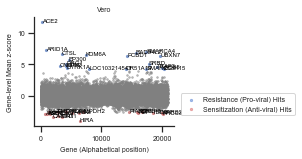

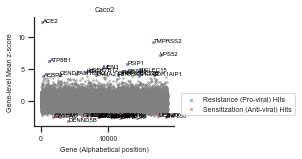

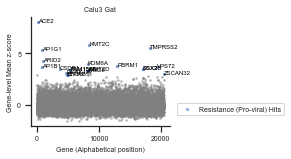

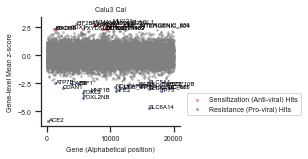

In [14]:
# Generate alphabetical gene scatter plot for Goujon data 

Goujon_keys = [key for key in screen_dict.keys() if 'Goujon' in key]

for key in Goujon_keys:
    df = screen_dict[key]
    title = ' '.join(key.split('_')[1:]) # Title with name of cell line and library (if applicable)
    filename = key
    score_col = df.columns[2] # 3rd column in data frame has residual_zscore or residual_zscore_avg
    
    if key == 'Goujon_Calu3_Cal': # positive hits are sensitization hits for activation screen 
        pos_res = False
    else:
        pos_res = True
    alphabetical_scatter(df=df, title=title,filename=filename, score_col=score_col, pos_res=pos_res)

### Volcano Plots

Volcano plots for Goujon screens and Wilen screen 

In [15]:
def volcano_plot(gene_residuals, num_hits_high, num_hits_low, control_name, title, guide_min, guide_max, annot = True, xlim_pad = 5, ylim_pad = 10): 
    '''
    Input: 1. gene residuals: df output from anchors.get_gene_residuals(), combined across conditions if necessary 
           2. num_hits_high: number of hits to annotate on the positive end of z-scores 
           3. num_hits_low: number of hits to annotate on the negative end of z-scores 
           4. control_name: list containing substrings that identify controls 
           5. title
           6. guide_min
           7. guide_max
           8. annot
           9. xlim_pad
           10. ylim_pad
    Output: volcano_plot with gene-level z-score on x-axis and -log10(FDR) on y-axis
    '''
    fig, ax = plt.subplots(figsize = (2, 2))
    
    # Filter gene residuals data frame by number of guides per gene 
    gene_residuals_filtered = gene_residuals.copy()[(gene_residuals['guides']>=guide_min) & (gene_residuals['guides']<=guide_max)]
    
    volcano_plot_df = gene_residuals_filtered[['Gene Symbol', 'residual_zscore', 'fdr_bh']].copy()

    volcano_plot_df['-log10(FDR)'] = volcano_plot_df['fdr_bh'].copy().apply(lambda x: -np.log10(x))
    # replace infinity values with 400 
    volcano_plot_df = volcano_plot_df.copy().replace(np.inf, 400)
    # store genes with dummy value so can be annotated in legend 
    logFDR_inf_genes = volcano_plot_df[volcano_plot_df['-log10(FDR)'].eq(400)]
    volcano_plot_df = volcano_plot_df.copy().dropna()
    
    sns.scatterplot(data = volcano_plot_df, x='residual_zscore', y='-log10(FDR)', color = 'grey', edgecolor=None, alpha=0.5, s=3, rasterized = True)
    
    # Annotate gene hits
    top_ranked_genes = volcano_plot_df.nlargest(num_hits_high, 'residual_zscore')
    bottom_ranked_genes = volcano_plot_df.nsmallest(num_hits_low, 'residual_zscore')
    ranked_genes = pd.concat([top_ranked_genes, bottom_ranked_genes]).reset_index(drop = True)
    labels = ranked_genes['Gene Symbol'].to_list() # genes to annotate
    ranked_genes = ranked_genes.dropna()
    if 'Calabrese' not in title:
        g = sns.scatterplot(data = top_ranked_genes, x='residual_zscore', y='-log10(FDR)', color = sns.color_palette('muted')[0], edgecolor=None, alpha=0.5, s=3, label = 'Resistance (Pro-viral) Hits', rasterized = True)
        if 'Gattinara' not in title: 
            g = sns.scatterplot(data = bottom_ranked_genes, x='residual_zscore', y='-log10(FDR)', color = sns.color_palette('muted')[3], edgecolor=None, alpha=0.5, s=3, label = 'Sensitization (Anti-viral) Hits', rasterized = True)
    else: # top and bottom ranked gene labels flipped for Calabrese screen 
        g = sns.scatterplot(data = bottom_ranked_genes, x='residual_zscore', y='-log10(FDR)', color = sns.color_palette('muted')[0], edgecolor=None, alpha=0.5, s=3, label = 'Resistance (Pro-viral) Hits', rasterized = True)
        g = sns.scatterplot(data = top_ranked_genes, x='residual_zscore', y='-log10(FDR)', color = sns.color_palette('muted')[3], edgecolor=None, alpha=0.5, s=3, label = 'Sensitization (Anti-viral) Hits', rasterized = True)
    if annot:
        for row in range(0,ranked_genes.shape[0]):
            g.text(ranked_genes['residual_zscore'][row]+0.01, ranked_genes['-log10(FDR)'][row], 
            ranked_genes['Gene Symbol'][row], horizontalalignment='left', fontsize = 7, color='black')
    
    # Annotate controls
    controls = get_controls(volcano_plot_df, control_name=control_name)
    sns.scatterplot(data = controls, x='residual_zscore', y='-log10(FDR)', color = sns.color_palette('Set2')[0], edgecolor=None, alpha=0.5, s=3, label = 'Controls', rasterized = True)

    filename = title 
    
    if not annot: # Remove all labels and legend so only points shown 
        title = ''
        plt.xlabel('')#, fontsize = 12)
        plt.ylabel('')
        ax.get_legend().remove()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    else:
        title = title.replace('_',' (') + ')'
        plt.legend(fontsize=7, loc = 'lower left', bbox_to_anchor=(1.05, 0.1), borderaxespad=0.)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.xlabel('Gene-level z-score', fontsize = 7)
        plt.ylabel('-log10(FDR)', fontsize = 7)
        plt.title(title, fontsize=7)
    
    ax.set_box_aspect(1)
    sns.despine()

    if not annot:
        filename = filename +'_unannotated'
    print(filename)
    gpp.savefig('../../Figures/volcano_plots/'+filename+'_volcano_plot.pdf', dpi = 300)
        
        


In [16]:
gene_residuals_dict = {}

# Vero-E6
gene_residuals_dict['Wilen'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/VeroE6_Wilen_indiv_v5.xlsx')
gene_residuals_dict['Goujon_Vero'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/VeroE6_Goujon_indiv_v5.xlsx', sheet_name='condition_genomewide_zscore')

# Calu-3 
# Gattinara 
gene_residuals_dict['Goujon_Calu3_Gat'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Calu3_Gattinara_Goujon_v3.xlsx', sheet_name='condition_genomewide_zscore')

# Calabrese
gene_residuals_dict['Goujon_Calu3_Cal'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Calu3_Calabrese_Goujon_indiv_v3.xlsx', sheet_name='condition_genomewide_zscore')

# Caco-2
gene_residuals_dict['Goujon_Caco2'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Caco2_Brunello_Goujon_v3.xlsx', sheet_name='condition_genomewide_zscore')

gene_residuals_dict


{'Wilen':                          condition Gene Symbol  guides   avg_lfc  \
 0       Cas9-v2_D10_5e6_Hi-MOI_lfc        A1BG       4 -0.448237   
 1       Cas9-v2_D10_5e6_Hi-MOI_lfc        A1CF       4 -0.086505   
 2       Cas9-v2_D10_5e6_Hi-MOI_lfc       A2ML1       4 -0.184050   
 3       Cas9-v2_D10_5e6_Hi-MOI_lfc     A3GALT2       4  0.646973   
 4       Cas9-v2_D10_5e6_Hi-MOI_lfc      A4GALT       4  1.000290   
 ...                            ...         ...     ...       ...   
 112745   Cas9-v2_D5_5e6_Hi-MOI_lfc      ZYG11A       4 -0.894369   
 112746   Cas9-v2_D5_5e6_Hi-MOI_lfc      ZYG11B       4 -0.578563   
 112747   Cas9-v2_D5_5e6_Hi-MOI_lfc         ZYX       4  0.045130   
 112748   Cas9-v2_D5_5e6_Hi-MOI_lfc       ZZEF1       4 -0.298979   
 112749   Cas9-v2_D5_5e6_Hi-MOI_lfc        ZZZ3       4 -2.041793   
 
         avg_lfc_reference  residual_zscore   p_value    fdr_bh  
 0                0.403122        -1.223387  0.221184  0.972373  
 1                0.212519   

In [17]:
import statsmodels
def condition_zscore_avg(df, gene_col = 'Gene Symbol', p_val_col = 'p_value', zscore_col = 'residual_zscore', guide_col='guides', guide_min=2, guide_max=4):
    '''
    Inputs: 1. condition_df_key: dictionary key corresponding to data frame 
                                 with gene-level residual z-scores separated by condition 
            2. gene_col: column name corresponding to gene annotations column
            3. p_val_col: column name corresponding to p-value column
            4. zscore_col: column name corresponding to residual z-scores column
    Output: combined_df: data frame with z-scores averaged across conditions, 
                         p-values combined using Fisher's method
                         -> used to calculate fdr_bh (Benjamini-Hochberg)
    '''
    df = df[(df[guide_col]>=guide_min) & (df[guide_col]<=guide_max)]
    # Average across conditions for volcano plot 
    # Combine p-values using Fisher's method
    p_value_combined_df = df[[gene_col, p_val_col]].groupby(gene_col, as_index = False)
    p_value_combined_df = p_value_combined_df.agg(lambda x: combine_pvalues(x.p_value.tolist())[1])

    # Average z-scores 
    avg_zscore_df = df[[gene_col, zscore_col]].groupby(gene_col, as_index = False)
    avg_zscore_df = avg_zscore_df.apply(np.mean)

    combined_df = pd.merge(avg_zscore_df, p_value_combined_df, on = gene_col, how = 'outer')
    # Calculate fdr_bh 
    combined_df['fdr_bh']= statsmodels.stats.multitest.multipletests(combined_df[p_val_col], method='fdr_bh')[1]
    combined_df_guides = pd.merge(df[[gene_col, guide_col]].copy(), combined_df, on=gene_col, how = 'right')
    combined_df_guides = combined_df_guides.drop_duplicates()
    return combined_df_guides

In [18]:
gene_residuals_combined_dict = {}

guide_min_dict = {'Goujon_Vero': 3,
                 'Wilen': 3,
                 'Goujon_Calu3_Cal': 2,
                 'Goujon_Calu3_Gat': 2,
                 'Goujon_Caco2': 3}

guide_max_dict = {'Goujon_Vero': 5,
                 'Wilen': 5,
                 'Goujon_Calu3_Cal': 4,
                 'Goujon_Calu3_Gat': 4,
                 'Goujon_Caco2': 5}


for key, df in gene_residuals_dict.items():
    guide_min = guide_min_dict[key]
    guide_max = guide_max_dict[key]
    
    gene_residuals_combined_dict[key] = condition_zscore_avg(df, guide_min=guide_min, guide_max=guide_max)
    
    
gene_residuals_combined_dict

{'Wilen':        Gene Symbol  guides  residual_zscore   p_value    fdr_bh
 0             A1BG       4        -0.646763  0.591858  0.999985
 5             A1CF       4         0.304112  0.944787  0.999985
 10           A2ML1       4         0.734528  0.463848  0.999985
 15         A3GALT2       4         0.458065  0.346321  0.999985
 20          A4GALT       4         0.986005  0.211429  0.865278
 ...            ...     ...              ...       ...       ...
 104615      ZYG11A       4        -0.818043  0.489042  0.999985
 104620      ZYG11B       4        -0.707780  0.567540  0.999985
 104625         ZYX       4         0.621299  0.666649  0.999985
 104630       ZZEF1       4         0.478167  0.584903  0.999985
 104635        ZZZ3       4        -1.675250  0.005725  0.104291
 
 [20928 rows x 5 columns],
 'Goujon_Vero':       Gene Symbol  guides  residual_zscore   p_value    fdr_bh
 0            A1BG       4         0.973708  0.138590  0.737081
 4            A1CF       4        -0.66

Vero-E6_Wilen
Wilen
Vero-E6_Goujon
Goujon_Vero
Calu3-Gattinara_Goujon
Goujon_Calu3_Gat
Calu3-Calabrese_Goujon
Goujon_Calu3_Cal
Caco2-Brunello_Goujon
Goujon_Caco2


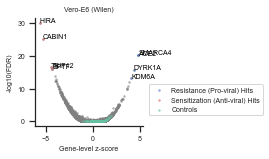

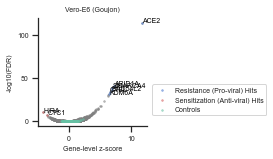

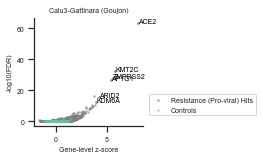

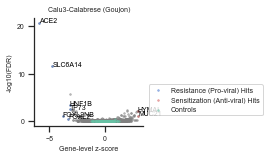

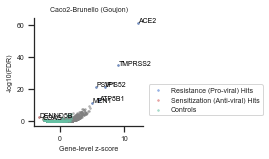

In [19]:
num_hit_dict = {'Wilen': [4, 4], 
                'Goujon_Vero':[6,2],
                'Goujon_Caco2':[6,2],
                'Goujon_Calu3_Cal':[2,6],
                'Goujon_Calu3_Gat':[6,0]}
title_condition_dict = {'Wilen': 'Vero-E6_Wilen',
              'Goujon_Vero':'Vero-E6_Goujon',
              'Goujon_Caco2':'Caco2-Brunello_Goujon',
              'Goujon_Calu3_Cal':'Calu3-Calabrese_Goujon',
              'Goujon_Calu3_Gat':'Calu3-Gattinara_Goujon'}
controls_condition_dict = {'Wilen':['NO_SITE'],
              'Goujon_Vero':['NO_SITE'],
              'Goujon_Caco2':['NO_SITE', 'ONE_INTERGENIC_SITE'],
              'Goujon_Calu3_Cal':['NO_SITE','ONE_INTERGENIC_SITE'],
              'Goujon_Calu3_Gat':['NO_SITE','ONE_INTERGENIC_SITE']}

guide_lims_dict = {'Wilen': [3, 5], 
                'Goujon_Vero':[3, 5],
                'Goujon_Caco2':[3, 5],
                'Goujon_Calu3_Cal':[2, 4],
                'Goujon_Calu3_Gat':[2,4]}

for key, df in gene_residuals_combined_dict.items():
    num_hits_high = num_hit_dict[key][0]
    num_hits_low = num_hit_dict[key][1]
    title = title_condition_dict[key] #+ '_Condition'
    guide_min = guide_lims_dict[key][0]
    guide_max = guide_lims_dict[key][1]
    control_name = controls_condition_dict[key]
    try:
        volcano_plot(df, num_hits_high, num_hits_low, control_name, title, guide_min, guide_max)
    except:
        pass
    print(key)


### Goujon Vero guide-level figures

In [20]:
Goujon_Vero_guide_level = pd.read_excel('../../Data/Processed/Individual_screens_v2/VeroE6_Goujon_indiv_v5.xlsx', sheet_name='guide-level_zscore')
# Initial population log-fold changes
Goujon_Vero_ini_pops = Goujon_Vero_guide_level.copy()[['Construct Barcode', 'unperturbed', 'lfc_reference']]
# Resistant population log-fold changes
Goujon_Vero_res_pops = Goujon_Vero_guide_level.copy()[['Construct Barcode', 'condition', 'lfc']]
Goujon_Vero_ini_pops = Goujon_Vero_ini_pops.rename(columns={'unperturbed':'condition', 'lfc_reference':'lfc'})

Goujon_Vero_guide_lfc_conditions = pd.concat([Goujon_Vero_ini_pops, Goujon_Vero_res_pops])
Goujon_Vero_guide_lfc_conditions


,Construct Barcode,condition,lfc
0,AAAAAAAAAAACTCAAAGAT,Vero E6 CRISPR population 1: CRISPR transduct...,0.072753
1,AAAAAAAAAAACTCAAAGAT,Vero E6 CRISPR population 1: CRISPR transduct...,0.072753
2,AAAAAAAAAAACTCAAAGAT,Vero E6 CRISPR population 1: CRISPR transduct...,0.072753
3,AAAAAAAAAAACTCAAAGAT,Vero E6 CRISPR population 2: CRISPR transducti...,-0.361541
4,AAAAAAAAACTGGAATCATG,Vero E6 CRISPR population 1: CRISPR transduct...,-0.298671
...,...,...,...
355479,TTTGTTTGCGGGTCACTTCG,Vero E6 population 2 screen 1 (CoV-2 Resistant...,1.692119
355480,TTTGTTTGGTAGCGTAACCT,Vero E6 population 1 screen 1A (CoV-2 Resistan...,-3.303127
355481,TTTGTTTGGTAGCGTAACCT,Vero E6 population 1 screen 1B (CoV-2 Resistan...,-3.303127
355482,TTTGTTTGGTAGCGTAACCT,Vero E6 population 1 screen 2 (CoV-2 Resistan...,-3.303127


Vero E6 population 1 screen 1A (CoV-2 Resistant cells, infection 1, round 1 )_lfc
Vero E6 population 2 screen 1 (CoV-2 Resistant cells, "infection 3")_lfc
Vero E6 population 1 screen 2  (CoV-2 Resistant cells, infection 2, started independently of 1A and 1B with lower cell density)_lfc
Vero E6 CRISPR  population 1: CRISPR transduction efficiency 7%_lfc
Vero E6 CRISPR population 2: CRISPR transduction efficiency 50%_lfc
Vero E6 population 1 screen 1B (CoV-2 Resistant cells, round 2 - performed on 1A surviving cells)_lfc


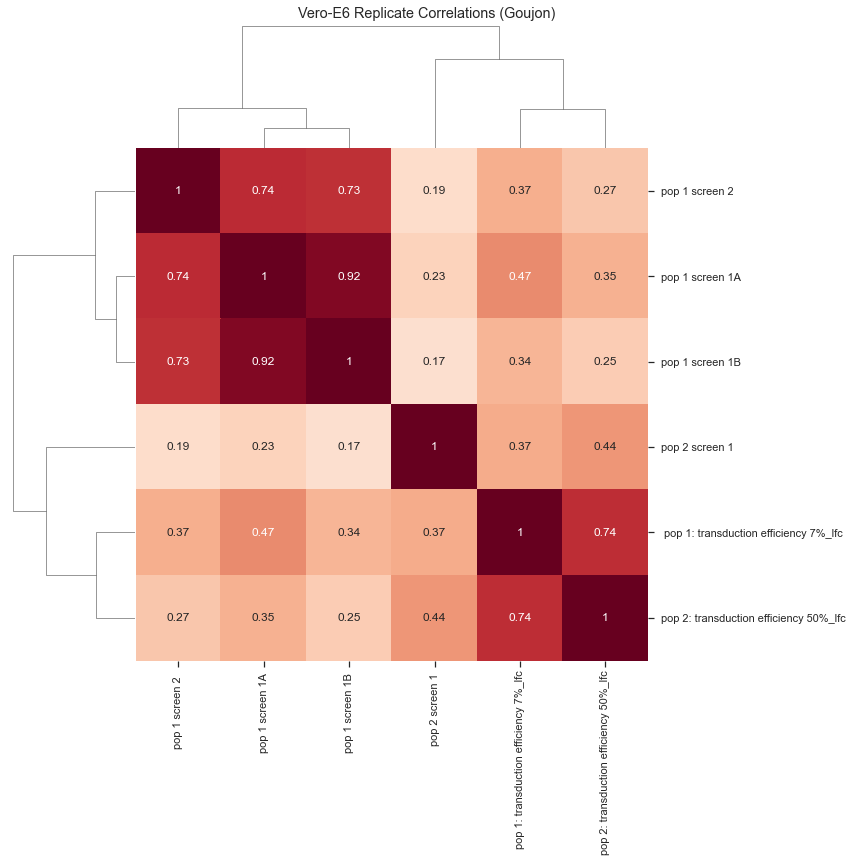

In [21]:
# Vero
labels = list(set(Goujon_Vero_guide_lfc_conditions['condition']))
guide_lfc_df_dict = {}
for label in labels:
    print(label)
    df = Goujon_Vero_guide_lfc_conditions.copy()[Goujon_Vero_guide_lfc_conditions['condition']==label]
    df[label] = df['lfc'].copy()
    new_df = df.copy().drop(['condition', 'lfc'], axis = 1)
    new_df = new_df.copy().drop_duplicates()
    guide_lfc_df_dict[label] = new_df.copy().reset_index(drop=True)


Goujon_Vero_rep_corr_df = pd.concat(guide_lfc_df_dict.values())
Goujon_Vero_rep_corr_df = fns.merge_dict_dfs(guide_lfc_df_dict, merge_col='Construct Barcode')
Goujon_Vero_rep_corr_df = Goujon_Vero_rep_corr_df.copy()[1:]
new_col_list = []
for col in Goujon_Vero_rep_corr_df.columns:
    new_col = col.split('(')[0]
    new_col1 = new_col.replace('Vero E6', '')
    new_col2 = new_col1.replace('population', 'pop')
    new_col3 = new_col2.replace('CRISPR ', '')
    new_col_list.append(new_col3)

Goujon_Vero_rep_corr_df.columns = new_col_list

c = sns.clustermap(Goujon_Vero_rep_corr_df.corr(), cbar_pos=None, cmap = gpp.diverging_cmap(), center=0, annot=True, figsize=(12, 12))
c.fig.suptitle('Vero-E6 Replicate Correlations (Goujon)', y=1)

gpp.savefig('../../Figures/Rep_Corr/Vero_Goujon_repcorr.pdf')


### Cell line scatter plots

In [22]:
control_flag_cols = [col for col in all_screens.columns if 'control' in col]
rank_cols = [col for col in all_screens.columns if 'Rank' in col]
cols_to_drop = control_flag_cols + rank_cols

all_screens_zscores = all_screens.copy().drop(cols_to_drop, axis =1)
all_screens_zscores

,Gene Symbol,residual_zscore_avg_Wilen,residual_zscore_avg_Goujon_Vero,residual_zscore_avg_Sanjana,residual_zscore_Puschnik,residual_zscore_avg_Poirier,residual_zscore_avg_Daelemans,residual_zscore_Zhang,residual_zscore_avg_Goujon_Caco2,residual_zscore_avg_Goujon_Calu3_Gat,residual_zscore_avg_Goujon_Calu3_Cal
0,SMARCA4,4.871878,6.936940,-1.347770,0.447325,1.728954,-0.277430,-0.350152,-0.257998,2.108117,-0.757486
1,ACE2,4.858969,11.712143,5.493899,5.892623,3.741293,2.831578,21.924745,12.246308,8.050874,-5.882191
2,DYRK1A,4.394741,4.439655,-0.903642,1.205009,0.962365,0.811692,0.752592,-0.836708,3.133949,NaN
3,KDM6A,4.084949,6.508141,-0.088095,-0.053609,0.529856,0.549728,0.986173,-0.325654,3.978881,-0.569885
4,DPF2,3.896036,4.703072,-0.719691,-1.500079,1.773889,-1.099927,3.109883,-0.368786,-0.337774,1.055956
...,...,...,...,...,...,...,...,...,...,...,...
28889,LOC102724832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.400220
28890,ONE_INTERGENIC_604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.580079
28891,ONE_INTERGENIC_656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.675589
28892,LOC107985220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.765579


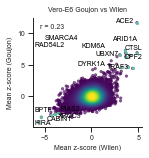

In [23]:
# Vero Screen comparison
sns.set_context('paper')
Vero_list = ['Wilen', 'Goujon_Vero']
Vero_cols = ['Gene Symbol']
for study in Vero_list:
    cols_to_add = [col for col in all_screens_zscores.columns if study in col]
    Vero_cols = Vero_cols + cols_to_add

Vero_df = all_screens_zscores[Vero_cols].dropna()

fig, ax = plt.subplots(figsize=(2,2))
ax = gpp.point_densityplot(Vero_df, 'residual_zscore_avg_Wilen', 'residual_zscore_avg_Goujon_Vero', s=6)

ax = gpp.add_correlation(Vero_df, 'residual_zscore_avg_Wilen', 'residual_zscore_avg_Goujon_Vero', fontsize= 7, loc='upper left')
top_ranked_Wilen = Vero_df.nlargest(20, 'residual_zscore_avg_Wilen')
top_ranked_Goujon_Vero = Vero_df.nlargest(20, 'residual_zscore_avg_Goujon_Vero')
top_ranked_Vero = pd.concat([top_ranked_Wilen, top_ranked_Goujon_Vero]).reset_index(drop = True).drop_duplicates()
bottom_ranked_Wilen = Vero_df.nsmallest(20, 'residual_zscore_avg_Wilen')
bottom_ranked_Goujon_Vero = Vero_df.nsmallest(20, 'residual_zscore_avg_Goujon_Vero')
bottom_ranked_Vero = pd.concat([bottom_ranked_Wilen, bottom_ranked_Goujon_Vero]).reset_index(drop = True).drop_duplicates()

ranked_Wilen = pd.concat([top_ranked_Wilen, bottom_ranked_Wilen])
ranked_Goujon_Vero = pd.concat([top_ranked_Goujon_Vero, bottom_ranked_Goujon_Vero])

# Label gene hits common to both screens 
common_ranked_Vero = pd.merge(ranked_Wilen, ranked_Goujon_Vero, on =['Gene Symbol', 'residual_zscore_avg_Wilen', 'residual_zscore_avg_Goujon_Vero'], how = 'inner')

# ranked_Vero = pd.concat([top_ranked_Vero, bottom_ranked_Vero])
sns.scatterplot(data = common_ranked_Vero, x='residual_zscore_avg_Wilen', y='residual_zscore_avg_Goujon_Vero', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in common_ranked_Vero.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_Wilen']+0.25, row['residual_zscore_avg_Goujon_Vero'], row['Gene Symbol'], size=7, 
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)


plt.title('Vero-E6 Goujon vs Wilen', fontsize=7)
plt.xlabel('Mean z-score (Wilen)', fontsize=7)
plt.ylabel('Mean z-score (Goujon)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)


# plt.gca().set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
sns.despine()
gpp.savefig('../../Figures/Scatterplots/Vero_GoujonvsWilen_scatterplot.pdf', dpi=300)



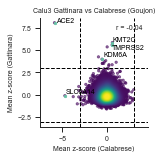

In [24]:
# Calu3 Screen comparison
Calu3_list = ['Goujon_Calu3_Cal', 'Goujon_Calu3_Gat']
Calu3_cols = ['Gene Symbol']
for study in Calu3_list:
    cols_to_add = [col for col in all_screens_zscores.columns if study in col]
    Calu3_cols = Calu3_cols + cols_to_add

Calu3_df = all_screens_zscores[Calu3_cols].dropna()

fig, ax = plt.subplots(figsize=(2,2))
ax = gpp.point_densityplot(Calu3_df, 'residual_zscore_avg_Goujon_Calu3_Cal', 'residual_zscore_avg_Goujon_Calu3_Gat', s=6)

ax = gpp.add_correlation(Calu3_df, 'residual_zscore_avg_Goujon_Calu3_Cal', 'residual_zscore_avg_Goujon_Calu3_Gat', loc='upper right',  fontsize= 7)

annot_genes = ['ACE2', 'TMPRSS2', 'KMT2C', 'SLC6A14', 'KDM6A']
annot_df = Calu3_df[Calu3_df['Gene Symbol'].isin(annot_genes)]
sns.scatterplot(data = annot_df, x='residual_zscore_avg_Goujon_Calu3_Cal', y='residual_zscore_avg_Goujon_Calu3_Gat', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

# top_ranked_Calu3genes = set(top_ranked_Calu3['Gene Symbol'].to_list())
#ax = gpp.label_points(Calu3_df, 'residual_zscore_avg_Goujon_Calu3_Cal', 'residual_zscore_avg_Goujon_Calu3_Cal', label=top_ranked_Calu3genes, label_col='Gene Symbol', bbox = dict(facecolor='white', alpha=0.75, edgecolor='black'))
texts= []
for j, row in annot_df.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_Goujon_Calu3_Cal'], row['residual_zscore_avg_Goujon_Calu3_Gat'], row['Gene Symbol'], size=7, 
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)#, arrowprops=dict(arrowstyle="-", color='black', lw=0.2))#, ax = ax)


plt.axvline(3, color = 'black', linewidth= 1, linestyle = '--')
plt.axhline(3, color = 'black', linewidth= 1, linestyle = '--')
plt.axvline(-3, color = 'black', linewidth= 1, linestyle = '--')
plt.axhline(-3, color = 'black', linewidth= 1, linestyle = '--')
plt.title('Calu3 Gattinara vs Calabrese (Goujon)', fontsize=7)
plt.xlabel('Mean z-score (Calabrese)', fontsize=7)
plt.ylabel('Mean z-score (Gattinara)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.gca().set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
sns.despine()
gpp.savefig('../../Figures/Scatterplots/Calu3_GatvsCal_scatterplot.pdf')


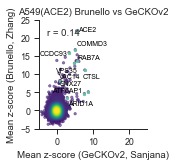

In [25]:
# A549 (ACE2) Screen comparison

A549_list = ['Sanjana', 'Zhang']
A549_cols = ['Gene Symbol']
for study in A549_list:
    cols_to_add = [col for col in all_screens_zscores.columns if study in col]
    A549_cols = A549_cols + cols_to_add


A549_df = all_screens_zscores[A549_cols].dropna()
#A549_df = A549_df_all.drop(cols_to_drop, axis = 1).dropna()

fig, ax = plt.subplots(figsize=(2,2))
ax = gpp.point_densityplot(A549_df, 'residual_zscore_avg_Sanjana', 'residual_zscore_Zhang', s=6)
#ax = sns.scatterplot(data = A549_df, x='residual_zscore_avg_Sanjana', y='residual_zscore_Zhang', color = 'grey')
ax = gpp.add_correlation(A549_df, 'residual_zscore_avg_Sanjana', 'residual_zscore_Zhang')
top_ranked_Sanjana = A549_df.nlargest(3, 'residual_zscore_avg_Sanjana')
top_ranked_Zhang = A549_df.nlargest(3, 'residual_zscore_Zhang')
A549_overlap_genes = ['ACE2', 'CTSL', 'ARID1A', 'VPS35', 'SNX27', 'RAB7A', 'VAC14']
A549_overlap_df = A549_df[A549_df['Gene Symbol'].isin(A549_overlap_genes)]
A549_annot_df = pd.concat([top_ranked_Sanjana, top_ranked_Zhang, A549_overlap_df]).drop_duplicates().reset_index(drop = True)

sns.scatterplot(data = A549_annot_df, x='residual_zscore_avg_Sanjana', y='residual_zscore_Zhang', color = sns.color_palette('Set2')[0], edgecolor=None, s=6)
# top_ranked_A549genes = top_ranked_A549['Gene Symbol'].to_list()
#ax = gpp.label_points(A549_df, 'residual_zscore_avg_Sanjana', 'residual_zscore_Zhang', label=top_ranked_A549genes, label_col='Gene Symbol', bbox = dict(facecolor='white', alpha=0.75, edgecolor='black'))
texts= []
for j, row in A549_annot_df.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_Sanjana'], row['residual_zscore_Zhang'], row['Gene Symbol'], size=7, 
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)#, arrowprops=dict(arrowstyle="-", color='black', lw=0.2))#, ax = ax)

plt.title('A549(ACE2) Brunello vs GeCKOv2')
plt.xlabel('Mean z-score (GeCKOv2, Sanjana)')
plt.ylabel('Mean z-score (Brunello, Zhang)')

plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.gca().set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
sns.despine()
gpp.savefig('../../Figures/Scatterplots/A549_BrunellovsGeCKOv2_scatterplot.pdf', dpi=300)
# fig.savefig('../../Figures/Scatterplots/A549_BrunellovsGeCKOv2_scatterplot.png', bbox_inches = 'tight')



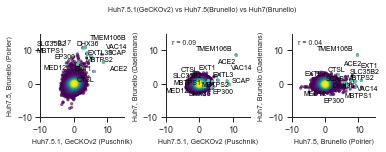

In [26]:
# Huh 7/7.5/7.5.1 Screen Comparison
Huh_list = ['Puschnik', 'Poirier', 'Daelemans']
Huh_cols = ['Gene Symbol']
for study in Huh_list:
    cols_to_add = [col for col in all_screens_zscores.columns if study in col]
    Huh_cols = Huh_cols + cols_to_add

Huh_df = all_screens_zscores[Huh_cols].dropna()

fig, axs = plt.subplots(ncols = 3, figsize = (6, 2))#, sharey = True)

# Huh7.5 hits from Venn diagram
Huh_annot_genes = ['ACE2',
 'CTSL',
 'EP300',
 'MED12',
 'VAC14',
 'TMEM106B',
 'SCAP',
 'DHX36',
 'MBTPS2',
 'SLC35B2',
 'EXT1',
 'MBTPS1',
 'EXTL3']

# Puschnik vs Poirier
gpp.point_densityplot(Huh_df.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_Poirier', ax = axs[0], s=6)
gpp.add_correlation(Huh_df.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_Poirier', ax = axs[0], fontsize=7)

Huh_annot_df = Huh_df[Huh_df['Gene Symbol'].isin(Huh_annot_genes)]
sns.scatterplot(data = Huh_annot_df, x='residual_zscore_Puschnik', y='residual_zscore_avg_Poirier', ax = axs[0], color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

axs[0].set_xlim(-10, 15)
axs[0].set_ylim(-10, 15)
axs[0].set_xlabel('Huh7.5.1, GeCKOv2 (Puschnik)', fontsize = 7)
axs[0].set_ylabel('Huh7.5, Brunello (Poirier)', fontsize = 7)

#plt.gca().set_aspect('equal', adjustable='box')
axs[0].set_box_aspect(1)

texts= []
for j, row in Huh_annot_df.iterrows():
    texts.append(axs[0].text(row['residual_zscore_Puschnik'], row['residual_zscore_avg_Poirier'], row['Gene Symbol'], size=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts, ax = axs[0])#, arrowprops=dict(arrowstyle="-", color='black', lw=0.2))#, ax = ax)



# Puschnik vs Daelemans
gpp.point_densityplot(Huh_df.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_Daelemans', ax = axs[1], s=6)
ax = gpp.add_correlation(Huh_df.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_Daelemans', ax = axs[1], fontsize=7)
sns.scatterplot(data = Huh_annot_df, x='residual_zscore_Puschnik', y='residual_zscore_avg_Daelemans', ax = axs[1], color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

axs[1].set_xlim(-10, 15)
axs[1].set_ylim(-10, 15)
axs[1].set_xlabel('Huh7.5.1, GeCKOv2 (Puschnik)', fontsize = 7)
axs[1].set_ylabel('Huh7, Brunello (Daelemans)', fontsize = 7)
#axs[1].gca().set_aspect('equal', adjustable='box')
axs[1].set_box_aspect(1)
texts= []
for j, row in Huh_annot_df.iterrows():
    texts.append(axs[1].text(row['residual_zscore_Puschnik'], row['residual_zscore_avg_Daelemans'], row['Gene Symbol'], size=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts, ax = axs[1])#, arrowprops=dict(arrowstyle="-", color='black', lw=0.2))#, ax = ax)


# Poirier vs Daelemans
gpp.point_densityplot(Huh_df.dropna(), 'residual_zscore_avg_Poirier', 'residual_zscore_avg_Daelemans', ax = axs[2], s=6)
ax = gpp.add_correlation(Huh_df.dropna(), 'residual_zscore_avg_Poirier', 'residual_zscore_avg_Daelemans', ax = axs[2], fontsize=7)
sns.scatterplot(data = Huh_annot_df, x='residual_zscore_avg_Poirier', y='residual_zscore_avg_Daelemans', ax = axs[2], color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

axs[2].set_xlim(-10, 15)
axs[2].set_ylim(-10, 15)
axs[2].set_xlabel('Huh7.5, Brunello (Poirier)', fontsize = 7)
axs[2].set_ylabel('Huh7, Brunello (Daelemans)', fontsize = 7)
#axs[2].gca().set_aspect('equal', adjustable='box')
axs[2].set_box_aspect(1)
texts= []
for j, row in Huh_annot_df.iterrows():
    texts.append(axs[2].text(row['residual_zscore_avg_Poirier'], row['residual_zscore_avg_Daelemans'], row['Gene Symbol'], size=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts, ax = axs[2])#, arrowprops=dict(arrowstyle="-", color='black', lw=0.2))#, ax = ax)



plt.suptitle('Huh7.5.1(GeCKOv2) vs Huh7.5(Brunello) vs Huh7(Brunello)', fontsize=7)
plt.subplots_adjust(wspace=0.5)
# #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_box_aspect(1)
sns.despine()
gpp.savefig('../../Figures/Scatterplots/Huh_comparison_scatterplot.pdf', dpi=300)
# fig.savefig('../../Figures/Scatterplots/Huh_comparison_scatterplot.png',bbox_inches = 'tight')


### Signal-to-noise (ROC-AUC)

In [27]:
# ROC-AUC (guide-level) using lfc from guide-residuals table
guide_residuals_dict = {}

guide_residuals_dict['Wilen'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/VeroE6_Wilen_indiv_v5.xlsx', sheet_name = 'guide-level_zscore')
guide_residuals_dict['Sanjana'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/A549_GeCKOv2_Sanjana_v2.xlsx', sheet_name = 'guide-level_zscore')
guide_residuals_dict['Puschnik'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Huh751_GeCKOv2_Puschnik_v2.xlsx', sheet_name = 'guide-level_zscore')
guide_residuals_dict['Poirier'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Huh75_Brunello_Poirier_v3.xlsx', sheet_name = 'guide-level_zscore')
guide_residuals_dict['Zhang'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/A549_Brunello_Zhang_v2.xlsx', sheet_name = 'guide-level_zscore')
guide_residuals_dict['Daelemans'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Huh7_Brunello_Daelemans_v3.xlsx', sheet_name = 'guide-level_zscore')
guide_residuals_dict['Goujon_Vero'] = Goujon_Vero_guide_level
guide_residuals_dict['Goujon_Caco2'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Caco2_Brunello_Goujon_v3.xlsx', sheet_name = 'guide-level_zscore')
guide_residuals_dict['Goujon_Calu3_Gat'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Calu3_Gattinara_Goujon_v3.xlsx', sheet_name = 'guide-level_zscore')
# guide_residuals_dict['Goujon_Calu3_Cal'] = pd.read_excel('../../Data/Processed/Individual_screens_v2/Calu3_Calabrese_Goujon_indiv_v3.xlsx', sheet_name = 'guide-level_zscore')

guide_residuals_dict


{'Wilen':            Construct Barcode Gene Symbol                    condition  \
 0       AAAAAAAAAAACTCAAAGAT         SET   Cas9-v2_D10_5e6_Hi-MOI_lfc   
 1       AAAAAAAAAAACTCAAAGAT         SET    Cas9-v2_D5_5e6_Hi-MOI_lfc   
 2       AAAAAAAAAAACTCAAAGAT         SET    Cas9-v2_D2_5e6_Hi-MOI_lfc   
 3       AAAAAAAAAAACTCAAAGAT         SET  Cas9-v2_D5_2.5e6_Hi-MOI_lfc   
 4       AAAAAAAAAAACTCAAAGAT         SET  Cas9-v2_D5_2.5e6_Lo-MOI_lfc   
 ...                      ...         ...                          ...   
 444350  TTTGTTTGGTAGCGTAACCT        DUXA   Cas9-v2_D10_5e6_Hi-MOI_lfc   
 444351  TTTGTTTGGTAGCGTAACCT        DUXA    Cas9-v2_D5_5e6_Hi-MOI_lfc   
 444352  TTTGTTTGGTAGCGTAACCT        DUXA    Cas9-v2_D2_5e6_Hi-MOI_lfc   
 444353  TTTGTTTGGTAGCGTAACCT        DUXA  Cas9-v2_D5_2.5e6_Hi-MOI_lfc   
 444354  TTTGTTTGGTAGCGTAACCT        DUXA  Cas9-v2_D5_2.5e6_Lo-MOI_lfc   
 
         residual  residual_z          unperturbed       lfc  lfc_reference  
 0       0.417325    0.

In [28]:
ess_genes = pd.read_csv('../../Data/External/Gene_sets_Hart/essential-genes.txt', sep = '\t', header = None)
tp_genes = ess_genes[0].to_list()
non_ess_genes = pd.read_csv('../../Data/External/Gene_sets_Hart/non-essential-genes.txt', sep = '\t', header = None)
fp_genes = non_ess_genes[0].to_list()
fp_genes
roc_auc_dict = {}
roc_df_dict = {}
roc_auc_value_df = pd.DataFrame()
prev_row = pd.DataFrame()
for key, df in guide_residuals_dict.items():
    row = pd.DataFrame()
    gene_col = 'Gene Symbol'
    score_col = 'lfc_reference'
    df = df.copy()[[gene_col, score_col, 'unperturbed']].drop_duplicates()
    ref_conditions = list(set(df['unperturbed']))

    if len(ref_conditions) > 2: # if multiple refereance samples 
        roc_df_list = []
        roc_auc_list = []
        for ref in ref_conditions:
            ref_df = df[df['unperturbed'].eq(ref)]
            roc_auc, roc_df = pool.get_roc_aucs(ref_df, tp_genes, fp_genes, gene_col, score_col, condition_col='unperturbed')
            roc_auc_list.append(roc_auc)
        roc_auc_df = pd.concat(roc_auc_list)
        roc_auc_df['Study'] = key

        roc_auc_dict[key] = roc_auc_df
    else:
        roc_auc, roc_df = pool.get_roc_aucs(df, tp_genes, fp_genes, gene_col, score_col, condition_col='unperturbed')

        roc_auc['Study'] = key
        roc_auc_dict[key] = roc_auc
        
roc_auc_value_df = pd.concat(roc_auc_dict.values())
roc_auc_value_df['ROC-AUC'] = roc_auc_value_df['ROC-AUC'].round(2)
roc_auc_value_df = roc_auc_value_df[['Study', 'unperturbed', 'ROC-AUC']]
roc_auc_value_df_avg = roc_auc_value_df.groupby('Study',as_index=False).agg(np.mean)
roc_auc_value_df_avg['ROC-AUC'] = roc_auc_value_df_avg['ROC-AUC'].copy().round(2)
roc_auc_value_df_avg


,Study,ROC-AUC
0,Daelemans,0.78
1,Goujon_Caco2,0.71
2,Goujon_Calu3_Gat,0.84
3,Goujon_Vero,0.84
4,Poirier,0.92
5,Puschnik,0.56
6,Sanjana,0.62
7,Wilen,0.82
8,Zhang,0.68


### Overall Heatmap comparison

In [30]:
all_title_dict = {'Wilen': 'Vero-E6_Wilen',
              'Sanjana': 'A549(ACE2)-GeCKOv2_Sanjana',
              'Puschnik': 'Huh7.5.1-GeCKOv2_Puschnik',
              'Poirier': 'Huh7.5-Brunello_Poirier',
              'Zhang': 'A549(ACE2)-Brunello_Zhang',
              'Daelemans':'Huh7-Brunello_Daelemans',
              'Goujon_Vero':'Vero-E6_Goujon',
              'Goujon_Caco2':'Caco-2_Brunello_Goujon',
              'Goujon_Calu3_Gat':'Calu-3_Gattinara_Goujon',
              'Goujon_Calu3_Cal':'Calu-3_Calabrese_Goujon'}

In [32]:
# Average z-scores by cell line (Vero-E6, A549, Huh7.5): 
Vero_grouped = col_avg(Vero_df, col_name='Vero_zscore_avg')
A549_grouped = col_avg(A549_df, col_name='A549_zscore_avg')

Huh7_5_list = ['Puschnik', 'Poirier']
Huh7_5_cols = ['Gene Symbol']
for study in Huh7_5_list:
    cols_to_add = [col for col in all_screens_zscores.columns if study in col]
    Huh7_5_cols = Huh7_5_cols + cols_to_add
    
Huh7_5_df = all_screens_zscores[Huh7_5_cols].dropna()
Huh7_5_grouped = col_avg(Huh7_5_df, col_name='Huh7.5_zscore_avg')

Goujon_cols = ['Gene Symbol'] + [col for col in all_screens_zscores.columns if 'Goujon' in col]
Goujon_cols.remove('residual_zscore_avg_Goujon_Vero')
Goujon_human_df = all_screens_zscores[Goujon_cols]

heatmap_dict = {'Vero': Vero_grouped,
               'A549': A549_grouped,
               'Huh7.5': Huh7_5_grouped,
                'Goujon': Goujon_human_df
               }

all_screens_zscores_grouped = fns.merge_dict_dfs(heatmap_dict)
all_screens_zscores_grouped

,Gene Symbol,Vero_zscore_avg,A549_zscore_avg,Huh7.5_zscore_avg,residual_zscore_avg_Goujon_Caco2,residual_zscore_avg_Goujon_Calu3_Gat,residual_zscore_avg_Goujon_Calu3_Cal
0,SMARCA4,5.904409,-0.848961,1.088139,-0.257998,2.108117,-0.757486
1,ACE2,8.285556,13.709322,4.816958,12.246308,8.050874,-5.882191
2,DYRK1A,4.417198,-0.075525,1.083687,-0.836708,3.133949,NaN
3,KDM6A,5.296545,0.449039,0.238124,-0.325654,3.978881,-0.569885
4,DPF2,4.299554,1.195096,0.136905,-0.368786,-0.337774,1.055956
...,...,...,...,...,...,...,...
28889,LOC102724832,NaN,NaN,NaN,NaN,NaN,2.400220
28890,ONE_INTERGENIC_604,NaN,NaN,NaN,NaN,NaN,2.580079
28891,ONE_INTERGENIC_656,NaN,NaN,NaN,NaN,NaN,2.675589
28892,LOC107985220,NaN,NaN,NaN,NaN,NaN,2.765579


#### Venn Diagram (Vero-E6 vs A549 (ACE2) vs Huh7.5)

In [33]:
# Only look at Vero-E5, A549 (ACE2), Huh7.5 so drop Caco-2 and Calu-3 columns 
Goujon_human_cols = list(Goujon_human_df.columns[1:])
Venn_Diagram_zscores = all_screens_zscores_grouped.drop(Goujon_human_cols, axis = 1)
Venn_Diagram_dict = {}
zscore_cols = list(Venn_Diagram_zscores.columns[1:])

# Select rows with genes with an average z-score greater than 5 in at least one cell line
for col in zscore_cols:
    Venn_Diagram_dict[col] = Venn_Diagram_zscores[Venn_Diagram_zscores.loc[:, col]>5]

Venn_Diagram_hits = pd.concat(Venn_Diagram_dict.values()).drop_duplicates()

# Among genes selected above, count z-scores > 3 as hits for Venn Diagram 
Venn_Diagram_bool_hits = Venn_Diagram_hits[['Gene Symbol']].copy()
for col in zscore_cols:
    Venn_Diagram_bool_hits[col] = Venn_Diagram_hits[col] > 3


# Venn_Diagram_bool_hits
    
# Hits common to all
Vero_A549_Huh = Venn_Diagram_bool_hits[Venn_Diagram_bool_hits.all(axis=1)]

# Hits in any 2 
TwoCellLines = Venn_Diagram_bool_hits[Venn_Diagram_bool_hits.sum(axis=1).eq(2)]
Vero_A549 = TwoCellLines[~TwoCellLines['Huh7.5_zscore_avg']] # select where Huh7.5 is False
Vero_Huh7_5 = TwoCellLines[~TwoCellLines['A549_zscore_avg']] # select where A549 is False
A549_Huh7_5 = TwoCellLines[~TwoCellLines['Vero_zscore_avg']] # select where Vero-E6 is False

# Hits in any single cell line
OneCellLine = Venn_Diagram_bool_hits[(Venn_Diagram_bool_hits.sum(axis=1).eq(1))]
OnlyVeroHits = OneCellLine[OneCellLine['Vero_zscore_avg']]
OnlyA549Hits = OneCellLine[OneCellLine['A549_zscore_avg']]
OnlyHuh7_5Hits = OneCellLine[OneCellLine['Huh7.5_zscore_avg']]

# Store all genes that overlap in at least two cell lines
overlapping_genes =  Vero_A549_Huh['Gene Symbol'].to_list()+TwoCellLines['Gene Symbol'].to_list()
overlapping_genes

['ACE2', 'CTSL', 'ARID1A', 'VAC14']

In [57]:
# Genes for each section 

# Vero only
OnlyVero_zscores = pd.merge(OnlyVeroHits[['Gene Symbol']], Venn_Diagram_hits, on = 'Gene Symbol', how = 'outer')
OnlyVero = OnlyVero_zscores.sort_values(by='Vero_zscore_avg', ascending = False)#.head(n=10)
OnlyVero_genes = list(OnlyVero['Gene Symbol'])

# A549 only
OnlyA549_zscores = pd.merge(OnlyA549Hits[['Gene Symbol']], Venn_Diagram_hits, on = 'Gene Symbol', how = 'outer')
OnlyA549 = OnlyA549_zscores.sort_values(by='A549_zscore_avg', ascending = False)
OnlyA549_genes = list(OnlyA549['Gene Symbol'])

# Huh7.5 only
OnlyHuh7_zscores = pd.merge(OnlyHuh7_5Hits[['Gene Symbol']], Venn_Diagram_hits, on = 'Gene Symbol', how = 'outer')
OnlyHuh7_5 = OnlyHuh7_zscores.sort_values(by='Huh7.5_zscore_avg', ascending = False)
OnlyHuh7_5_genes = list(OnlyHuh7_5['Gene Symbol'])

# Vero and A549
Vero_A549_zscores = pd.merge(Vero_A549[['Gene Symbol']], Venn_Diagram_hits, on = 'Gene Symbol', how = 'outer')
Vero_A549_genes = Vero_A549_zscores.sort_values(by='Vero_zscore_avg', ascending = False)
Vero_A549_genes = list(Vero_A549_genes.copy()['Gene Symbol'])

# Vero and Huh7.5 
Vero_Huh7_5_zscores = pd.merge(Vero_Huh7_5[['Gene Symbol']], Venn_Diagram_hits, on = 'Gene Symbol', how = 'outer')
Vero_Huh7_5_genes = Vero_Huh7_5_zscores.sort_values(by='Vero_zscore_avg', ascending = False)
Vero_Huh7_5_genes = list(Vero_Huh7_5_genes.copy()['Gene Symbol'])


# A549 and Huh.5
A549_Huh7_5_zscores = pd.merge(A549_Huh7_5[['Gene Symbol']], Venn_Diagram_hits, on = 'Gene Symbol', how = 'outer')
A549_Huh7_5_genes = A549_Huh7_5_zscores.sort_values(by='Vero_zscore_avg', ascending = False)
A549_Huh7_5_genes = list(A549_Huh7_5_genes.copy()['Gene Symbol'])


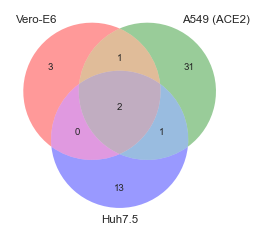

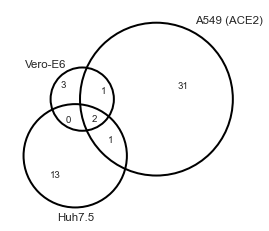

In [40]:
# Circles: A = Vero-E6, B = A549 (ACE2), C = Huh7.5 
fig, ax = plt.subplots()
# Unweighted
venn.venn3_unweighted(subsets=(len(OnlyVeroHits), # Abc
                     len(OnlyA549Hits), # aBc
                     len(Vero_A549), # ABc
                     len(OnlyHuh7_5Hits), # abC
                     len(Vero_Huh7_5), # AbC
                     len(A549_Huh7_5), # aBC
                     len(Vero_A549_Huh)), # ABC
                      set_labels=('Vero-E6', 'A549 (ACE2)', 'Huh7.5')) # ABC
fig, ax = plt.subplots()

fig = plt.gcf()
gpp.savefig('../../Figures/VennDiagram_VeroA549Huh75_unweighted_color.pdf')

# Weighted 
v = venn.venn3(subsets=(len(OnlyVeroHits), # Abc
                     len(OnlyA549Hits), # aBc
                     len(Vero_A549), # ABc
                     len(OnlyHuh7_5Hits), # abC
                     len(Vero_Huh7_5), # AbC
                     len(A549_Huh7_5), # aBC
                     len(Vero_A549_Huh)), # ABC
                      set_labels=('Vero-E6', 'A549 (ACE2)', 'Huh7.5')) # ABC
circles = venn.venn3_circles(subsets=(len(OnlyVeroHits), # Abc
                     len(OnlyA549Hits), # aBc
                     len(Vero_A549), # ABc
                     len(OnlyHuh7_5Hits), # abC
                     len(Vero_Huh7_5), # AbC
                     len(A549_Huh7_5), # aBC
                     len(Vero_A549_Huh))) # ABC

patch_ids = ['100', '110', '010', '101', '111', '011', '001']
for patch in patch_ids:
    v.get_patch_by_id(patch).set_color('white')

fig = plt.gcf()
gpp.savefig('../../Figures/VennDiagram_VeroA549Huh75_weighted.pdf')


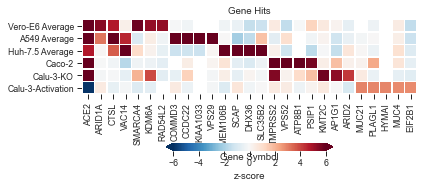

In [36]:
top_ranked = select_top_ranks(all_screens_zscores_grouped)
# include overlapping genes from Venn diagram, if not already included
overlapping_df = all_screens_zscores_grouped[all_screens_zscores_grouped['Gene Symbol'].isin(overlapping_genes)]
# overlapping_df = overlapping_df.sort_values(by=list(overlapping_df.columns[1:]), ascending=False)
heatmap_df = pd.concat([overlapping_df, top_ranked]).drop_duplicates()
# heatmap_df=heatmap_df.sort_values(by=list(heatmap_df.columns[1:]), ascending=False)
heatmap_df
all_zscore_df_heatmap = heatmap_df.copy().set_index('Gene Symbol')#.dropna(axis = 0)
fig, ax = plt.subplots(figsize=(6, 6))

ylabels = ['Vero-E6 Average', 'A549 Average', 'Huh-7.5 Average', 'Caco-2', 'Calu-3-KO', 'Calu-3-Activation']
for col in all_zscore_df_heatmap.columns:
    if 'Goujon' in col:
        key = '_'.join(col.split('_')[-2:])
        if 'Goujon' not in key:
            key = 'Goujon_' + key
    else:
        key = col.split('_')[-1]

g = sns.heatmap(all_zscore_df_heatmap.T, mask = all_zscore_df_heatmap.T.isnull(), cmap = gpp.diverging_cmap(), square=True, yticklabels=ylabels,#xticklabels=xlabels,#yticklabels=ylabels,
                center=0, annot=False, cbar_kws={'orientation':'horizontal','shrink':0.5,'extend':'both', 'label':'z-score'}, linecolor='white', linewidths=0.5, vmin = -6, vmax = 6)#, 'orientation': orientation})#, vmin = vmin, vmax = vmax, fmt='.2f')


plt.title('Gene Hits')
plt.yticks(rotation = 0)
gpp.savefig('../../Figures/Heatmaps/Grouped_gene_hits_horizontal_unannotated.pdf', bbox_inches = 'tight')


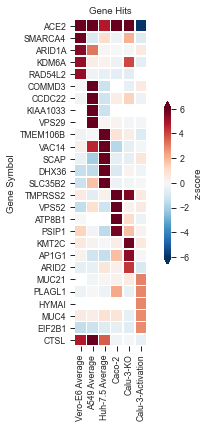

In [37]:
top_ranked = select_top_ranks(all_screens_zscores_grouped)

# include overlapping genes from Venn diagram, if not already included
overlapping_df = all_screens_zscores_grouped[all_screens_zscores_grouped['Gene Symbol'].isin(overlapping_genes)]
heatmap_df = pd.concat([top_ranked, overlapping_df]).drop_duplicates()

all_zscore_df_heatmap = heatmap_df.copy().set_index('Gene Symbol')#.dropna(axis = 0)
fig, ax = plt.subplots(figsize=(6, 6))

xlabels = ['Vero-E6 Average', 'A549 Average', 'Huh-7.5 Average', 'Caco-2', 'Calu-3-KO', 'Calu-3-Activation']
for col in all_zscore_df_heatmap.columns:
    if 'Goujon' in col:
        key = '_'.join(col.split('_')[-2:])
        if 'Goujon' not in key:
            key = 'Goujon_' + key
    else:
        key = col.split('_')[-1]

g = sns.heatmap(all_zscore_df_heatmap, mask = all_zscore_df_heatmap.isnull(), cmap = gpp.diverging_cmap(), square=True, xticklabels=xlabels,#yticklabels=ylabels,
                center=0, annot=False, cbar_kws={'shrink':0.5,'extend':'both', 'label':'z-score'}, linecolor='white', linewidths=0.5, vmin = -6, vmax = 6)#, 'orientation': orientation})#, vmin = vmin, vmax = vmax, fmt='.2f')


plt.title('Gene Hits')
plt.yticks(rotation = 0)
gpp.savefig('../../Figures/Heatmaps/Grouped_gene_hits_horizontal_unannotated_vertical.pdf', bbox_inches = 'tight')